# Homework 1: Radial velocity statistics

In this notebook we try to clarify what the nature of the motions is in the transition zone in which the convective motions turn into wave motions as the radius increases. The goal is to experiment with different statistical approaches to characterize this transition layer, in which both types of flow charateristics appear to superimpose.

We will 
* load the 3D data for a given dump
* extract the 3D velocity components in an already interpolated form on a sphere of given radius

We then provide the following plots:
* Mollweide projections of $u_\mathrm{r}$
* $u_\mathrm{r}$ probability mass function
* $u_\mathrm{r}$ spread as a function of azimuthal angle $\phi$


The Mollweide representations of the radial velocity at a given radius have been discussed in class. The [Mollweide movie](https://nextcloud.computecanada.ca/index.php/s/r6LHDRc6LfgkHQR) (you have to download the linked movie to your computer) provides an overview. According to the movie dump 4447 appears as not unusual, in the sense that the imprint of convection on the $u_r$ distribution according to the visual appearance is not particularly strong.

Familiarize yourself with this template notebook, and recall the data structures used and how they are analysed in the cell `# u_r analysis plots`. Then use this template to explore the following questions. 

##### Questions
1. Using dump 4447 compare the results of the Kolmogorov-Smirnov test and the Anderson-Darling test to see if the $u_r$ distribution represents a normal distribution at radius 2200Mm. Consider the two options for the number of points on the sphere, which are `# reduced npoints` and `# max npoints`. What is the difference for these different cases, and what is the reason for the difference?
2. Extend your analysis to these radii: 1800, 1690, 1610Mm. How does the deviation from a normal distribution change as the radius decreases?
4. Try to answer the question if this type of statistical analysis is useful in order to determine the emerging deviation from a nearly-normal distribution from larger to smaller radii, and in particular if it is more predictive than just looking and skew and kurtosis or some combination of these two.


In [1]:
%pylab ipympl
import os, sys, pickle, time
from multiprocessing import Pool
from matplotlib import pyplot as plp
import matplotlib.colors as colors
from scipy import stats
from scipy import interpolate
from scipy.optimize import curve_fit
from nugridpy import utils as ut
cb = ut.linestylecb # colours

# the PPM python package for 3D PPMstar data analysis 
# lives on GitHub: https://github.com/PPMstar/PyPPM
# we should have the latest version

# for use on niagara jupyter 
#ppmpy_dir = '/scratch/f/fherwig/fherwig/repos/PyPPM'
# for use on ppmstar hub on https://www.ppmstar.org
ppmpy_dir = "/user/repos/PyPPM"

sys.path.insert(0,ppmpy_dir)
from ppmpy import ppm
print(inspect.getfile(ppm))

# set cycling combination of color-blind labels, glyphs, styles
lll= 4*['-', '--', ':', '-.']
markers = ['X','h','<','>','s','^','d','X','p']
random.shuffle(lll)
CB_color_cycle = 2*['#4daf4a', '#a65628', '#984ea3',
                  '#ff7f00', '#f781bf', '#377eb8',
                  '#999999', '#e41a1c', '#dede00']
random.shuffle(CB_color_cycle)
random.shuffle(lll)
# CB_color_cycle = cbs
# rc('axes', prop_cycle=(cycler('color', CB_color_cycle[0:8]) + cycler('marker',markers[0:8])+cycler('linestyle',lll)))
rc('axes', prop_cycle=(cycler('color', CB_color_cycle[0:15]) +cycler('linestyle',lll[0:15])))

# named tuple for using rprofs and momsdata
# moms data are almost always used alongside rprof data and therefore it is recommended 
# to create a convenient dictionary that will hold the rprof and moms instance 
import collections
hydro = collections.namedtuple('hydro', ['moms','rprof'])

# turn off matplotlib messages
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)


Matplotlib is building the font cache; this may take a moment.


Populating the interactive namespace from numpy and matplotlib
/user/repos/PyPPM/ppmpy/ppm.py


In [2]:
# there are two data access points
# the first is slow but has all dumps, loading one dump takes about 20min
data_dir = '/user/niagara.scratch.ppmstar'
# the second is faster, but has only these dumps:
# 4120  4183  4325  4447  4474  4550
# use this as a default
data_dir = '/data/ASDR-team/PPMstar/H-core-M25'
run_dir = 'M276-1000x-768'

moms_dir = os.path.join(data_dir,run_dir,'moms/myavsbq')
rprof_dir = os.path.join(data_dir,run_dir,'prfs')

# M276 - a list of variables available in these moms files:
var_list = ['xc','ux','uy','uz','|ut|','|ur|','|w|','T','rho','fv'] 
dump = 4447    # initialize with this dump

In [3]:
def Gauss(x, A, B):
    y = A*np.exp(-1*B*x**2)
    return y

In [4]:
# initialize a collection of an instance of a radial profile and 3D briquette data set (called "moms" data)
start_time = time.time()
myrun = hydro(ppm.MomsDataSet(moms_dir,init_dump_read=dump,dumps_in_mem=2,var_list=var_list,\
                              rprofset=ppm.RprofSet(rprof_dir),verbose=0),
              ppm.RprofSet(rprof_dir))
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

290 rprof files found in '/data/ASDR-team/PPMstar/H-core-M25/M276-1000x-768/prfs/.
Dump numbers range from 4000 to 4289.
290 rprof files found in '/data/ASDR-team/PPMstar/H-core-M25/M276-1000x-768/prfs/.
Dump numbers range from 4000 to 4289.
Execution time: 5.3915488719940186 seconds


In [5]:
# methods from ppm.py have doc strings
myrun.moms.sphericalHarmonics_lmax?

Signature: myrun.moms.sphericalHarmonics_lmax(radius)
Docstring:
Calculate the maximum l (minimum angular scale) that can be resolved with our moments data
resolution. This is simply using the nyquist sampling theorem:

lambda = 2 * pi * r / sqrt(l*(l+1))
lambda_min = 2 * dx

With large l, sqrt(l*(l+1)) ~ l
lmax ~ pi * r / dx

-------------------------------------------------------------------------------------------
Keep in mind that for a given lmax:

The number of theta subdivisions across its domain is N = 2*(l+1)
The number of phi subdivisions across its domain is 2*N = 4*(l+1)
The number of points being interpolated to is npoints = 8*(l+1)**2

Parameters
----------
radius: float
    The radius that you want to know the maximum l resolvable

Returns
-------
lmax: int
    The maximum l resolvable
N: int
    The number of subdivisions of theta between np.pi and 0
npoints: int
    The number of points to be interpolated at "radius"
File:      /user/repos/PyPPM/ppmpy/ppm.py
Type:     

## Drawing a radial velocity distribution at a given radius
The following cell interpolates from the 3D Cartesian 3-compponent velocity data the radial velocity component on a sphere of given radius for as many points as the grid resolution allows at that radius:

```
ur_r, theta_r,phi_r = myrun.moms.get_spherical_interpolation('|ur|',myradius ...
```

One can then use `u_r` to test if the distribution is consistent with, e.g., the normal distribution. Or one can create sub distributions in different directions of the full $4\pi$ sphere to test their similarity.

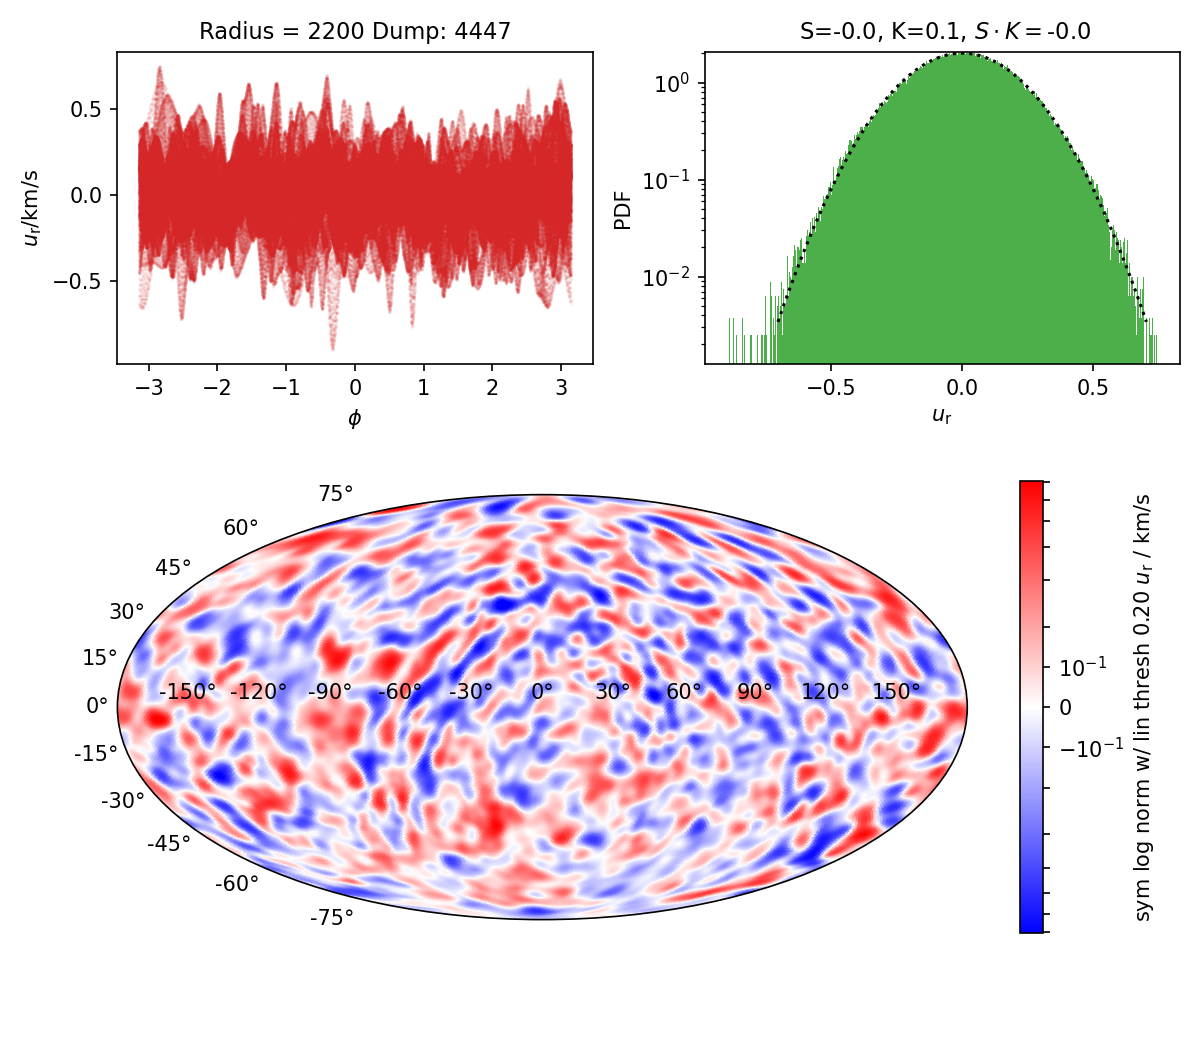

In [7]:
# u_r analysis plots
myradius=2200
# vscale_dic[myradius] = 1.5

rcParams.update({
    "axes.labelsize": 10,
    "font.size": 9,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

# max npoints
npoints = myrun.moms.sphericalHarmonics_lmax(myradius)[-1]
# reduced npoints
# npoints = int(min(8*(myrun.moms.sphericalHarmonics_lmax(myradius)[0]/10)**2\
#                   ,npoints)) # replace l with l/10, in effect consider only up to l=23

ur_r, theta_r,phi_r = myrun.moms.get_spherical_interpolation('|ur|', myradius, npoints=npoints, plot_mollweide=True)
ur_r *= 1000.      # factor 1000 make km/s

ur_sort = copy(ur_r)
ur_sort.sort()
np_permille =int(len(ur_sort)/1000)
ur_min_mean,ur_max_mean = np.mean(ur_sort[:np_permille]),np.mean(ur_sort[-np_permille:])
ur_sort=""
SD,S,K = np.std(ur_r),stats.skew(ur_r),stats.kurtosis(ur_r); SK = S*K

# a bit more than max(abs(v)), read of first diagram
vscale = max(abs(ur_min_mean),ur_max_mean)
vmin,vmax = vscale*array([-1,1]) 
# linthresh=0.1; linscale=1.*log10(1./linthresh); linthresh=0.1*vmax
linthresh = SD; linscale = 0.5*(log10(vmax)-log10(SD))

ifig=186;close(ifig);
fig=figure(ifig,dpi=150,figsize=(8,7))
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(phi_r,ur_r,'.',markersize=1.,color='tab:red',alpha=0.075)
ax1.set_xlabel('$\\phi$'); ax1.set_ylabel("$u_\mathrm{r} / \mathrm{km/s}$")
ax1.set_title(f"Radius = {myradius:4d} Dump: {dump:4d}")
fig.tight_layout()

ax2 = plt.subplot2grid((3, 2), (0, 1))
S,K = stats.skew(ur_r),stats.kurtosis(ur_r); SK = S*K
data = ax2.hist(ur_r,density=True,bins=1000,log=True)
ydata,xdata=data[0:2]; dx=diff(xdata)[0]; xdata = xdata[:-1]+0.5*dx
yminmax = (min(ydata[where(ydata>0.)]),max(ydata))
parameters, covariance = curve_fit(Gauss, xdata, ydata)
xx = linspace(vmin,vmax,100)
ax2.plot(xx,Gauss(xx,*parameters),color='k'); ylim(yminmax)
ax2.set_xlabel("$u_\mathrm{r}$"),ylabel('PDF')
ax2.set_title(f" S={S:3.1f}, K={K:3.1f}, $S \\cdot K=${SK:3.1f} ")

mwp = plt.subplot2grid((3, 2), (1, 0), colspan=2, rowspan=2, projection='mollweide')
mwps=mwp.scatter(phi_r, theta_r, s=(72./fig.dpi)**2, marker=',', c=ur_r, cmap='bwr',\
   norm=colors.SymLogNorm(linthresh=linthresh, linscale=linscale, vmin=vmin, vmax=vmax,base=10.)) # with base keyword for JL3
    # norm=colors.SymLogNorm(linthresh=linthresh, linscale=linscale, vmin=vmin, vmax=vmax))       # without base for older JL images
cbar = fig.colorbar(mwps, extend='neither',shrink=0.7); cbar.set_label(f"sym log norm w/ lin thresh {linthresh:3.2f} "+"$u_\mathrm{r}$ / km/s")

fig.tight_layout()
fig.savefig(run_dir+f"mollw-ur-{myradius:4d}.png",bbox_inches='tight')



In [12]:
# Answer questions below ...